In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

from scipy.stats import multivariate_normal

from sklearn.preprocessing import StandardScaler


%matplotlib inline

<b> Implementing Anomaly Detection </b> <br>
Working with a dataset representing throughput (mb/s) and latency of servers.

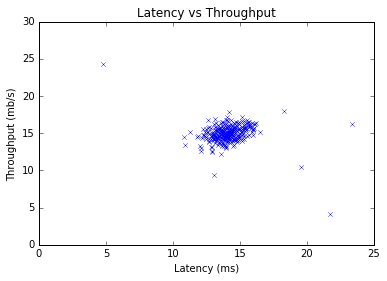

In [149]:
data = loadmat('ex8data1.mat')

# 307x2
X = data['X']

plt.scatter(X[:,0:1], X[:,1:2], c='b', marker='x', lw=0.4, alpha=1)
plt.title('Latency vs Throughput')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

<b> Taking mean and variance per feature and using that to calculate PDF </b>

In [150]:
# Doing it by hand but can use EllipticEnvelope from sklearn.covariance 
def get_gaussian(X, mu, sigma2):
    
    if len(sigma2)==1:
            sigma2 = np.diag(sigma2)
    
    return multivariate_normal(mean=mu, cov=sigma2).pdf(X)


def estimate_params(X):
    
    mu = np.mean(X ,axis=0)
    sigma2 = np.var(X, axis=0)
    
    return mu, sigma2

mu, sigma2 = estimate_params(X)

<b> Using values calculated above to plot contour lines as decision thresholds </b>

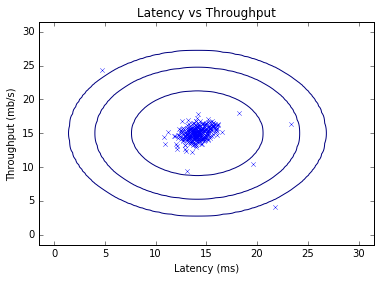

In [151]:
xx, yy = np.meshgrid(np.linspace(0, 30, 100), np.linspace(0, 30, 100))
Z = get_gaussian(np.c_[xx.reshape(-1,1), yy.reshape(-1,1)], mu, sigma2).reshape(xx.shape)

plt.scatter(X[:,0:1], X[:,1:2], c='b', marker='x', lw=0.4, alpha=1)
plt.title('Latency vs Throughput')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.contour(xx, yy, Z, levels=np.logspace(-20, 1, 4))

In [152]:
X_cv, y_cv = data['Xval'], data['yval']

mu_cv, sigma2_cv = estimate_params(X_cv)
gaus = get_gaussian(X_cv, mu_cv, sigma2_cv)

from __future__ import division

def get_epsilon(gaus, y_cv):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    stepsize = (np.amax(gaus)-np.amin(gaus)) / 1000

    for epsilon in np.arange(np.amin(gaus)+stepsize, np.amax(gaus), stepsize):
    
        y_gaus = (gaus<epsilon).reshape(-1, 1)
    
        tp = np.sum(np.all(((y_gaus==1), (y_cv==1)), axis=0))
        fp = np.sum(np.all(((y_gaus==1), (y_cv==0)), axis=0))
        fn = np.sum(np.all(((y_gaus==0), (y_cv==1)), axis=0))
    
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
    
        f1 = (2*prec*rec)/(prec+rec)
    
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
            
    return best_epsilon

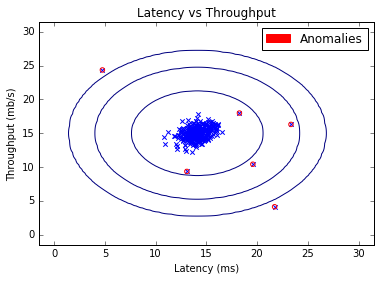

In [153]:
clf_anomalies = get_gaussian(X, mu, sigma2)<get_epsilon(gaus, y_cv)

import matplotlib.patches as mpatches

plt.scatter(X[:,0:1], X[:,1:2], c='b', marker='x', alpha=1)
plt.scatter(X[clf_anomalies][:,0:1], X[clf_anomalies][:,1:2], marker='o', facecolors='none', edgecolors='red')
plt.title('Latency vs Throughput')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.contour(xx, yy, Z, levels=np.logspace(-20, 1, 4))

red_patch = mpatches.Patch(color='red')
plt.legend([red_patch],['Anomalies'])

<b> Using defined functions to detect anomalies in higher dimensional data </b>

In [154]:
data2 = loadmat('ex8data2.mat')

# X1 = 1000x11
X1, X1_cv, y1_cv = data2['X'], data2['Xval'], data2['yval']

mu_1, sigma2_1 = estimate_params(X1)
gaus_1 = get_gaussian(X1, mu_1, sigma2_1)

mu_1_cv, sigma2_1_cv = estimate_params(X1_cv)
gaus_cv = get_gaussian(X1_cv, mu_1_cv, sigma2_1_cv)
epsilon = get_epsilon(gaus_cv, y1_cv)

anomalies = np.sum(gaus_1 < epsilon)

print 'Epsilon: {0} \nNumber of anomalies: {1}'.format(epsilon, anomalies)

Epsilon: 1.66205871119e-18 
Number of anomalies: 134
